<a href="https://colab.research.google.com/github/jiiwon129/ESAA/blob/main/ESAA_YB_WEEK9_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **[ 개념정리 ]**

**09 분류 실습 - 캐글 산탄데르 고객 만족 예측**

---

**데이터 전처리**
- __.info(): feature type, null value 확인
- __.describe(): 각 feature의 값 분포 확인
  - 편차가 너무 심할 경우 변환 or 삭제
- train_test_split()
  - 원본 데이터에서 학습/테스트 데이터 세트 분리
  - XGBoost의 조기중단(early stopping)의 검증 데이터 세트로 사용을 위해 한 번 더  분리
- eval_set=[(X_tr,y_tr},(X_val,y_val)]

**XGBoost 모델 학습과 하이퍼 파라미터 튜닝**
- HyperOpt 이용
  - 검색 공간 설정:
    - max_depth, min_child_weight, colsample_bytree, learning_rate
  - 목적 함수 설정:
    - XGBClassifier Class 설정
    - K-Fold 교차 검증 방식 적용
    - 학습용 데이터를 다시 학습/검증용 데이터로 분리하여 학습 수행 (__.fit())
    - 1로 예측한 확률값 추출
    - K개의 fold로 계산된 roc auc score 값의 평균값 반환
    - **HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾음 -> (-1)을 곱한 뒤 반환**
- fmin() 함수로 최적의 하이퍼 파라미터 도출
  - fn, space, algo, max_evals, trials, rstate.. 인자 설정

+ plot_importance() (in xgboost module)
  - 튜닝된 모델에서의 각 feature의 중요도 그래프

**LightGBM 모델 학습과 하이퍼 파라미터 튜닝**
- HyperOpt 이용
  - 검색 공간 설정:
    - num_leaves, max_depth, min_child_samples, subsample, learning_rate
  - 목적 함수 설정:
    - LGBMClassifier Class 설정
    - K-Fold 교차 검증 방식 적용
    - 학습용 데이터를 다시 학습/검증용 데이터로 분리하여 학습 수행 (__.fit())
    - 1로 예측한 확률값 추출
    - K개의 fold로 계산된 roc auc score 값의 평균값 반환
    - **HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾음 -> (-1)을 곱한 뒤 반환**
- fmin() 함수로 최적의 하이퍼 파라미터 도출
  - fn, space, algo, max_evals, trials, rstate.. 인자 설정

**10 분류 실습 - 캐글 신용카드 사기 검출**

---

**언더 샘플링과 오버 샘플링의 이해**

- 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제를 해결하는 방안
  - 오버 샘플링 방식이 예측 성능상 상대적으로 많이 이용

[ 언더 샘플링 ]
- 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
  - 과도하게 정상 레이블로 학습/예측하는 부작용 개선
- 너무 많은 정상 레이블 데이터를 감소시켜서 정상 레이블의 경우 제대로 된 학습을 수행할 수 없음

[ 오버 샘플링 ]
- 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
- 동일한 데이터를 단순히 증식하는 방법은 과적합되기 때문에 의미가 X -> 원본 데이터의 피처 값들을 아주 약간만 변경 후 증식
- 대표적으로 SMOTE(Synthetic Minority Over-Sampling Technique) 방법
  - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 '약간' 차이가 나는 새로운 데이터를 생성
  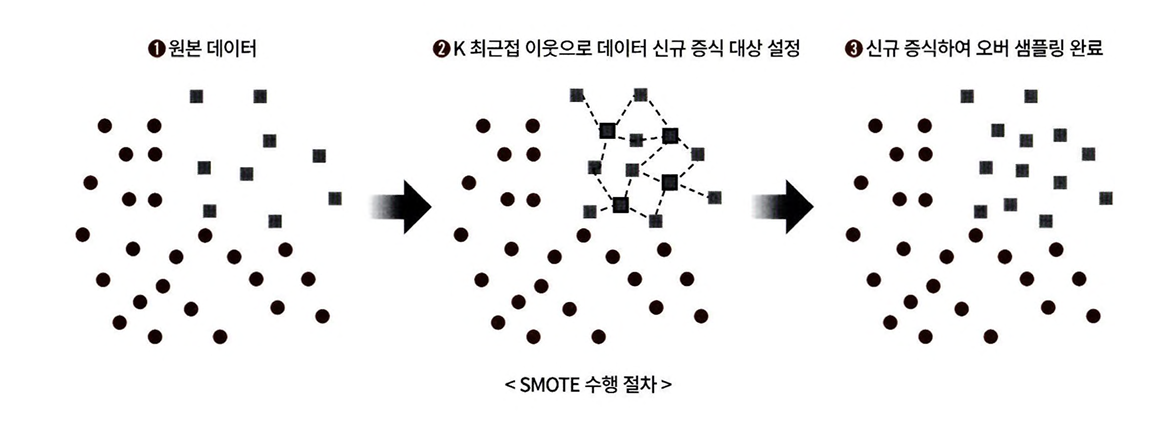

**데이터 일차 가공 및 모델 학습/예측/평가**

```
def get_processed_df(df=None):
  df_copy=df.copy()
  df_copy.drop() # 데이터 피처 값 확인 후 불필요한 피처 삭제
  return df_copy
```

```
def get_train_test_dataset(df=None):
  df_copy=get_preprocessed_df(df)
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]

  X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,
  test_size=0.3,random_state=0,
  stratify=y_target)

  return X_train,X_test,y_train,y_test
```

테스트 데이터 세트를 전체의 30%인 Straified 방식으로 추출

  -> 학습 데이터 세트와 테스트 데이터 세트의
레이블 값 분포도를 서로 동일하게 만듦

< 극도로 불균형한 레이블 값 분포도를 가진 데이터 세트 >
- LGBMClassifier Class 생성 시 **boost_from_average=False** 파라미터 설정

**StandardScaler()** : 정규분포 변환

```
from sklearn.preprocessing import StandardScaler

amount_n=StandardScaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
```

**log1p()** : 로그 변환

```
import numpy as np

amount_n=np.log1p(df_copy['Amount'])
```

**이상치 데이터 제거 후 모델 학습/예측/평가**

이상치(Outlier)
- 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
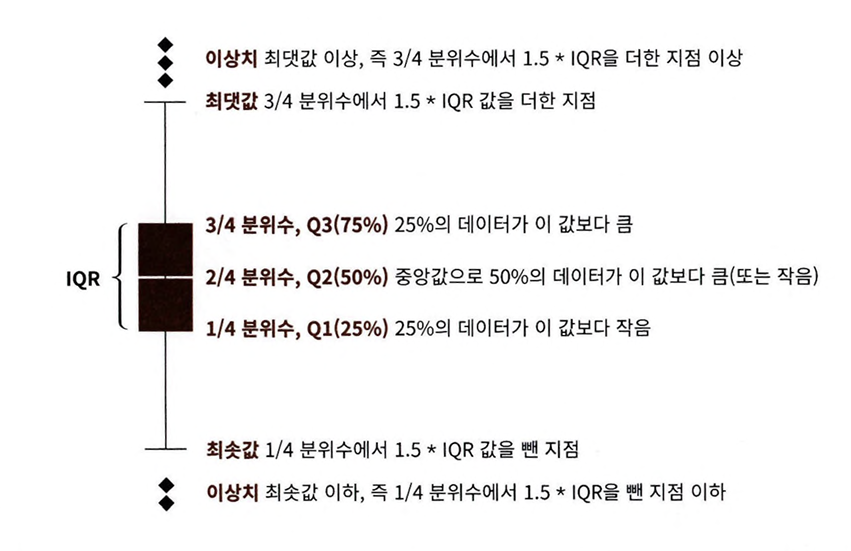

```
import numpy as np

def get_outlier(df=None,column=None,weight=1.5):
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values,25)
  quantile_75=np.percentile(fraud.values,75)

  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75-iqr_weight

  outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index
```

특정 칼럼의 이상치 데이터를 삭제하는 로직 추가 코드
```
outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
df_copy.drop(outlier_index,axis=0,inplace=True)
```

**SMOTE 오버 샘플링 적용 후 모델 학습/예측/평기**

```
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over,y_train_over=smote.fit_resample(X_train,y_train)
```

### **[ 필사 ]**

**09 분류 실습 - 캐글 산탄데르 고객 만족 예측**

데이터 전처리

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
cust_df=pd.read_csv('/content/drive/MyDrive/ESAA YB/dataset/santander-customer-satisfaction/train_santander.csv',
                    encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [4]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_features,y_labels,
                                               test_size=0.2,random_state=0)
train_cnt=y_train.count()
test_cnt=y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape: {1}'.format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape: (15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [9]:
# X_train,y_train을 다시 학습과 검증 데이터 세트로 분리.
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.3,random_state=0)

XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf=XGBClassifier(n_estimators=500,learning_rate=0.05,random_state=156,
                      early_stopping_rounds=100,eval_metric='auc')

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr,y_tr,
            eval_set=[(X_tr,y_tr),(X_val,y_val)],
            verbose=False)

xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8417


In [15]:
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space={'max_depth':hp.quniform('max_depth',5,15,1),
                  'min_child_weight':hp.quniform('min_child_weight',1,6,1),
                  'colsample_bytree':hp.uniform('colsample_bytree',0.5,0.95),
                  'learning_rate':hp.uniform('learning_rate',0.01,0.2)
}

In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
  xgb_clf=XGBClassifier(n_estimators=100,
                        max_depth=int(search_space['max_depth']),
                        min_child_weight=int(search_space['min_child_weight']),
                        colsample_bytree=search_space['colsample_bytree'],
                        learning_rate=search_space['learning_rate'],
                        early_stopping_rounds=30,eval_metric='auc')

  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index,val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
    X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    xgb_clf.fit(X_tr,y_tr,
                eval_set=[(X_tr,y_tr),(X_val,y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_val,xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개의 k-fold로 계산된 roc_auc 값의 평균값을 반한하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [26]:
from hyperopt import fmin,tpe,Trials

trials=Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func,
          space=xgb_search_space,
          algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수 지정
          trials=trials,
          rstate=np.random.default_rng(seed=30))
print('best:',best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[1]	validation_0-auc:0.84185	validation_1-auc:0.81151
[2]	validation_0-auc:0.83892	validation_1-auc:0.81016
[3]	validation_0-auc:0.84844	validation_1-auc:0.81883
[4]	validation_0-auc:0.85049	validation_1-auc:0.82190
[5]	validation_0-auc:0.85235	validation_1-auc:0.82399
[6]	validation_0-auc:0.85587	validation_1-auc:0.82399
[7]	validation_0-auc:0.85787	validation_1-auc:0.82579
[8]	validation_0-auc:0.86054	validation_1-auc:0.82705
[9]	validation_0-auc:0.86040	validation_1-auc:0.82705
[10]	validation_0-auc:0.86323	validation_1-auc:0.82919
[11]	validation_0-auc:0.86510	validation_1-auc:0.83027
[12]	validation_0-auc:0.86679	validation_1-auc:0.83074
[13]	validation_0-auc:0.86800	validation_1-auc:0.83093
[14]	validation_0-auc:0.86846	validation_1-auc:0.83219
[15]	validation_0-auc:0.86955	validation_1-auc:0.83237
[16]	validation_0-auc:0.87072	validation_1-auc:0.83218
[17]	validation_0-auc:0.87214	validation_1-auc:0.83306
[18]	validation_0-auc:0.87242	validati

In [27]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf=XGBClassifier(n_estimators=500,learning_rate=round(best['learning_rate'],5),
                      max_depth=int(best['max_depth']),
                      min_child_weight=int(best['min_child_weight']),
                      colsample_bytree=round(best['colsample_bytree'],5),
                      early_stopping_rounds=100,
                      eval_metric='auc'
                      )

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr,y_tr,
            eval_set=[(X_tr,y_tr),(X_val,y_val)])
xgb_roc_score=roc_auc_score(y_test,xgb_clf.predict(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83018	validation_1-auc:0.80525
[1]	validation_0-auc:0.84043	validation_1-auc:0.81460
[2]	validation_0-auc:0.83824	validation_1-auc:0.81236
[3]	validation_0-auc:0.84803	validation_1-auc:0.82040
[4]	validation_0-auc:0.85082	validation_1-auc:0.82147
[5]	validation_0-auc:0.85076	validation_1-auc:0.82291
[6]	validation_0-auc:0.85164	validation_1-auc:0.82304
[7]	validation_0-auc:0.85110	validation_1-auc:0.82269
[8]	validation_0-auc:0.85423	validation_1-auc:0.82449
[9]	validation_0-auc:0.85563	validation_1-auc:0.82733
[10]	validation_0-auc:0.85713	validation_1-auc:0.82694
[11]	validation_0-auc:0.85769	validation_1-auc:0.82804
[12]	validation_0-auc:0.85884	validation_1-auc:0.82859
[13]	validation_0-auc:0.85928	validation_1-auc:0.82845
[14]	validation_0-auc:0.85968	validation_1-auc:0.82828
[15]	validation_0-auc:0.86080	validation_1-auc:0.82815
[16]	validation_0-auc:0.86164	validation_1-auc:0.82834
[17]	validation_0-auc:0.86245	validation_1-auc:0.82915
[18]	validation_0-au

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf,ax=ax,max_num_features=20,height=0.4)

LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=500,
                        early_stopping_rounds=100,eval_metric='auc')

eval_set=[(X_tr,y_tr),(X_val,y_val)]
lgbm_clf.fit(X_tr,y_tr,eval_set=eval_set)

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [ ]:
lgbm_search_space={'num_leaves':hp.quniform('num_leaves',32,64,1),
                   'max_depth':hp.quniform('max_depth',100,160,1),
                   'min_child_samples':hp.quniform('min_child_samples',60,100,1),
                   'subsample':hp.uniform('subsample',0.7,1),
                   'learning_rate':hp.uniform('learning_rate',0.01,0.2)}

In [ ]:
def objective_func(search_space):
  lgbm_clf=LGBMClassifier(n_estmators=100,
                          num_leaves=int(search_space['num_leaves']),
                          max_depth=int(search_space['max_depth']),
                          min_child_samples=int(search_space['min_child_samples']),
                          subsample=search_space['subsample'],
                          learning_rate=search_space['learning_rate'],
                          early_stopping_rounds=30,eval_metric='auc')
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf=KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
    X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    lgbm_clf.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_yal,lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin,tpe,Trials

trials=Trials()

# fmin() 함수를 호출, max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func,
          space=lgbm_search_space,
          algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수 지정
          trials=trials,
          rstate=np.random.default_rng(seed=30))

print('best:',best)

In [ ]:
lgbm_clf=LGBMClassifier(n_estimators=500,
                        num_leave=int(best['num_leaves']),
                        max_depth=int(best['max_depth']),
                        min_child_samples=int(best['min_child_samples']),
                        subsample=round(best['subsample'],5),
                        learning_rate=round(best['learning_rate'],5),
                        early_stopping_rounds=100,
                        eval_metric='auc')

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr,y_tr,eval_set=[(X_tr,y_tr),(X_val,y_val)])
lgbm_roc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

**10 분류 실습 - 캐글 신용카드 사기 검출**

언더 샘플링과 오버 샘플링의 이해

In [30]:
!pip install imbalanced-learn

데이터 일차 가공 및 모델 학습/예측/평가

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv('/content/drive/MyDrive/ESAA YB/dataset/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [32]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [33]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy

In [34]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy=get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분할.
  # stratify=y_target으로 Stratified 기반 분할
  X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0,
                                                 stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

In [35]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [36]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,roc_auc_score

def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  f1=f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc=roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [37]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression(max_iter=1000)
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1:0.7194, AUC:0.9741


In [38]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행.
def get_model_train_eval(model,ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None) :
  model.fit(ftr_train,tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test,pred,pred_proba)

불균형 레이블 값 분포도를 가진 데이터 세트
- LGBMClassifier class 생성 시 boost_from_average=False 설정

In [39]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000,
                        num_leaves=64,
                        n_jobs=-1,
                        boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

데이터 분포도 변환 후 모델 학습/예측/평가

정규 분포 변환

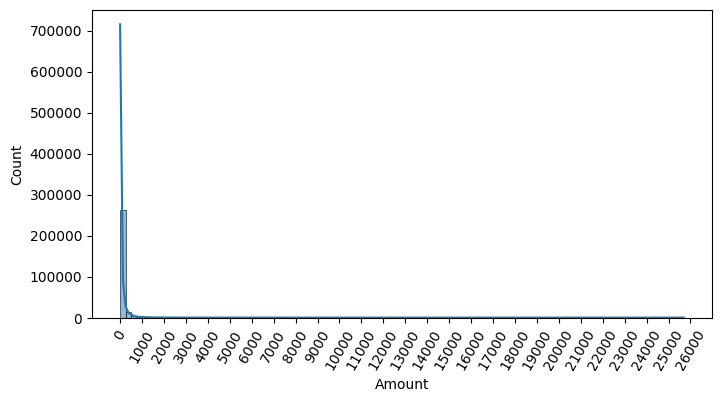

In [40]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'],bins=100,kde=True)
plt.show()

In [41]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled',amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [42]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1:0.7294, AUC:0.9706
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

log 변환

In [43]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  return df_copy

In [44]:
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,
                     tgt_train=y_train,tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,
                     tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1:0.7120, AUC:0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

이상치 데이터 제거 후 모델 학습/예측/평가

<Axes: >

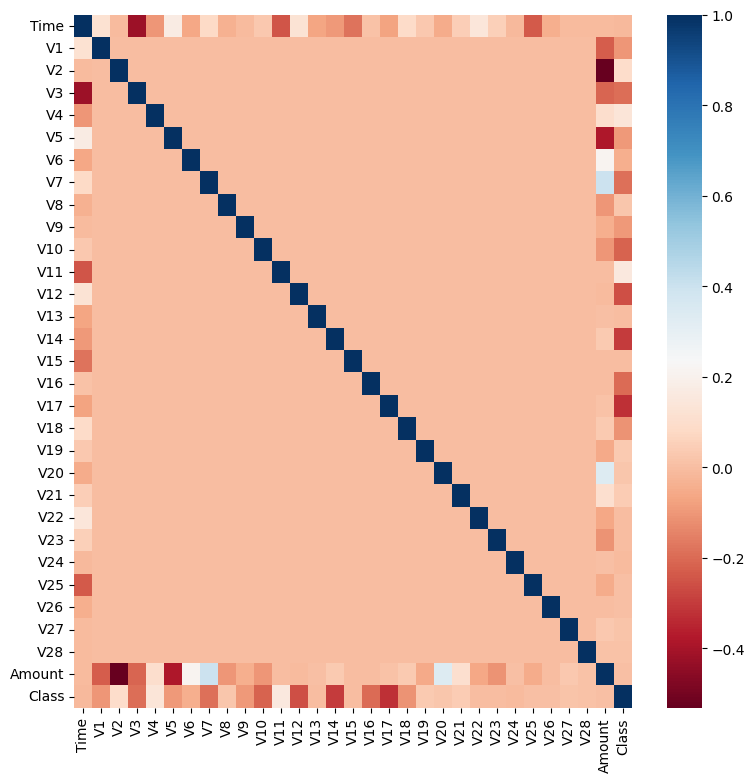

In [45]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [50]:
import numpy as np

def get_outlier(df=None,column=None,weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values,25)
  quantile_75=np.percentile(fraud.values,75)
  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75+iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [51]:
outlier_index=get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스:',outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [52]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_proprecessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled',amount_n)
  df_copy.drop(['Time','Amount'],axis=1,inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
  df_copy.drop(outlier_index,axis=0,inplace=True)
  return df_copy

X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1:0.7120, AUC:0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [53]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over,y_train_over=smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:',X_train.shape,y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:',X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [54]:
lr_clf=LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,
                     tgt_test=y_test)

오차 행렬
[[83322  1973]
 [   15   133]]
정확도: 0.9767, 정밀도: 0.0632, 재현율: 0.8986, F1:0.1180, AUC:0.9804


In [59]:
def precision_recall_curve_plot(y_test,pred_proba_c1):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as ticker
  %matplotlib inline

  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions,recalls,thresholds=precision_recall_curve(y_test,pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary=thresholds.shape[0]
  plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
  plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start,end=plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value')
  plt.ylabel('Precision and Recall value')
  plt.legend()
  plt.grid()
  plt.show()

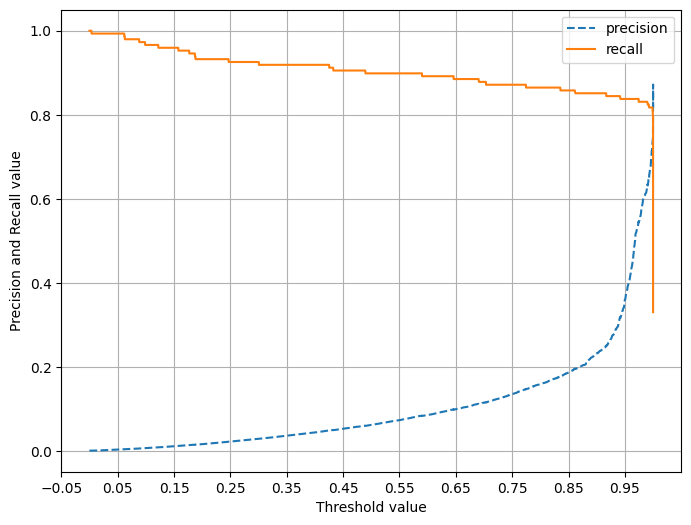

In [61]:
from sklearn.metrics import precision_recall_curve
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [62]:
lgbm_clf=LGBMClassifier(n_estimators=1000,
                        num_leaves=64,
                        n_jobs=-1,
                        boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi